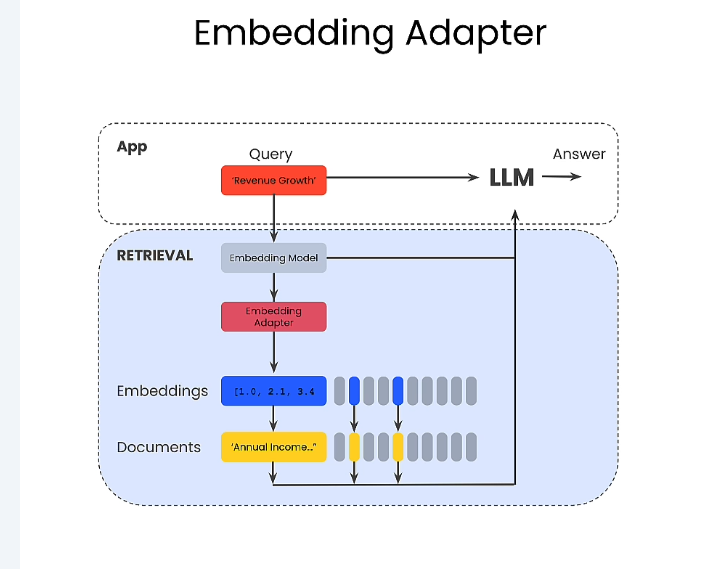

In [1]:
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import numpy as np
# import umap
from tqdm import tqdm

import torch

In [2]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

2025-03-25 01:26:33.112149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742844393.136384   92766 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742844393.143633   92766 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742844393.163168   92766 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742844393.163201   92766 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742844393.163203   92766 computation_placer.cc:177] computation placer alr

349

In [3]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']

In [4]:
# umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
# projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

In [5]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import os
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("GROQ_API_KEY")

In [6]:
template = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
            "Suggest 10 to 15 short questions that are important to ask when analyzing an annual report. "
            "Do not output any compound questions (questions with multiple sentences or conjunctions)."
            "Output each question on a separate line divided by a newline.")
])

In [7]:
llm = ChatGroq(
                api_key=api_key,
                model_name="llama3-70b-8192",
                temperature=0.2,  # Lower temperature for more consistent medical responses
                max_tokens=2048    # Ensure sufficient tokens for detailed answers
            )
output_parser = StrOutputParser()
chain = template|llm|output_parser

In [8]:
generated_queries = chain.invoke({})
generated_queries = generated_queries.split('\n')

In [9]:
for query in generated_queries:
    print(query)

Here are 15 short questions to ask when analyzing an annual report:

What is the company's primary business and industry?

What is the company's revenue growth rate over the past three years?

What is the company's net income margin?

What is the company's return on equity (ROE)?

What is the company's debt-to-equity ratio?

What is the company's current ratio?

What is the company's cash flow from operations?

What is the company's capital expenditure trend?

What is the company's research and development expense as a percentage of revenue?

What is the company's dividend payout ratio?

What is the company's employee count and labor cost trend?

What is the company's geographic revenue breakdown?

What is the company's product or service revenue mix?

What is the company's management's compensation structure?

What is the company's auditor's opinion on the financial statements?


In [11]:
results = chroma_collection.query(query_texts=generated_queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

In [12]:
# Define the prompt template
template = ChatPromptTemplate([
    ("system", "You are a helpful expert financial research assistant. You help users analyze financial statements "
               "to better understand companies. For the given query, evaluate whether the following statement is relevant. "
               "Output only 'yes' or 'no'."),
    ("human", "Query: {query}, Statement: {statement}")
])

# Initialize the ChatGroq model
llm = ChatGroq(
    api_key=api_key,
    model_name="llama3-70b-8192",
    temperature=0.2,
    max_tokens=1  # Restricting output to 'yes' or 'no'
)

# Define the output parser
output_parser = StrOutputParser()

# Create the chain
chain = template | llm | output_parser

# Function to evaluate results
def evaluate_results(query, statement):
    response = chain.invoke({"query": query, "statement": statement})
    return 1 if response.strip().lower() == "yes" else -1

# Example usage
query = "Is the company profitable?"
statement = "The company reported a net income of $10 million for the fiscal year."

# result = evaluate_results(query, statement)
# print(result)  # Output: 1 or -1


In [13]:
retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

In [14]:
adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []

In [15]:
for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document))

100%|██████████| 31/31 [13:44<00:00, 26.58s/it]


In [16]:
len(adapter_labels)

310

In [17]:
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

In [18]:
dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

## Setting up the model

In [19]:
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)


In [20]:
def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

In [21]:
# Initialize the adaptor matrix
mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

In [22]:
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()
        

  0%|          | 0/100 [00:00<?, ?it/s]/home/nafiz/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


In [23]:
print(f"Best loss: {min_loss.detach().numpy()}")

Best loss: 0.6737921833992004


In [24]:
test_vector = torch.ones((mat_size,1))
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

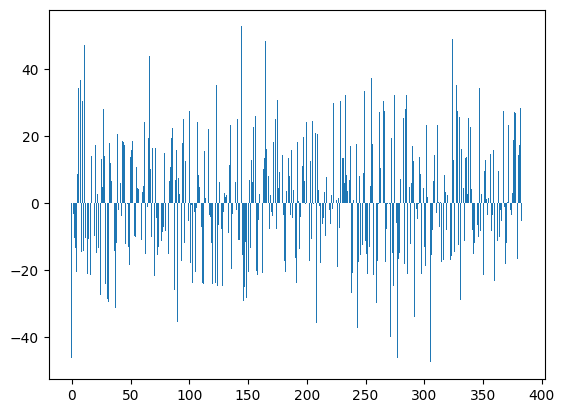

In [25]:
import matplotlib.pyplot as plt
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()


In [ ]:
query_embeddings = embedding_function(generated_queries)
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T

# projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
# projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

In [ ]:
# # Plot the projected query and retrieved documents in the embedding space
# plt.figure()
# plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
# plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
# plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")

# plt.gca().set_aspect('equal', 'datalim')
# plt.title("Adapted Queries")
# plt.axis('off')
# plt.legend()

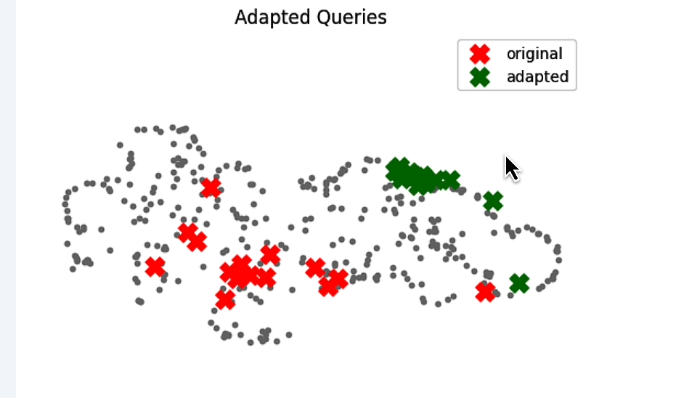